## a-AlphaBio homework 
### misc. futzing about.... prob messy

In [1]:
%load_ext autoreload

In [2]:
%autoreload
# import libraries
import numpy as np
import pickle as pk
import pandas as pd
import math
import os
import yaml
import sys
sys.path.append('/Users/markthompson/Documents/dev/a-alphaBio-homework/datasets/') 
print(sys.path)

import matplotlib.pyplot as plt
%matplotlib inline

['/Users/markthompson/Documents/dev/a-alphaBio-homework/notebooks', '/Users/markthompson/anaconda3/envs/avm-dvm/lib/python39.zip', '/Users/markthompson/anaconda3/envs/avm-dvm/lib/python3.9', '/Users/markthompson/anaconda3/envs/avm-dvm/lib/python3.9/lib-dynload', '', '/Users/markthompson/anaconda3/envs/avm-dvm/lib/python3.9/site-packages', '/Users/markthompson/Documents/dev/a-alphaBio-homework/datasets/']


In [3]:
# Read the config
config_path = '../config/mlp_params.yaml'  
with open(config_path, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

config = config['model_params']
print(config)

# hardwire the block size to 265
config['block_size'] = 265


{'block_size': 248, 'mask_prob': 0.0, 'mlp_dropout': 0.2, 'accelerator': 'gpu', 'devices': 1, 'batch_size': 2048, 'num_workers': 5, 'grad_norm_clip': 1.0, 'num_epochs': 10000, 'log_dir': './lightning_logs/mlp_model/', 'train_data_path': '../data/train_set.csv', 'test_data_path': '../data/val_set.csv', 'checkpoint_name': 'None', 'learning_rate': 0.0001, 'lr_gamma': 0.999, 'betas': [0.9, 0.95], 'checkpoint_every_n_train_steps': 100, 'save_top_k': 1, 'monitor': 'loss', 'mode': 'min', 'log_every_nsteps': 10, 'inference_results_folder': './inference_results/', 'seed': 3407}


In [4]:
import math
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

#--------------------------------------------------------
# Code fragments taken from:
# * https://github.com/barneyhill/minBERT
# * https://github.com/karpathy/minGPT

# protein sequence data taken from:
# * https://www.nature.com/articles/s41467-023-39022-2
# * https://zenodo.org/records/7783546
#--------------------------------------------------------

class scFv_Dataset(Dataset):
    """
    Emits batches of amino acid sequences and binding energies
    """
    def __init__(self, config, csv_file_path, skiprows=0, inference=False):  
        super().__init__()
        self.config = config
        self.inference = inference
        print('reading the data from:', csv_file_path)
        self.df = pd.read_csv(csv_file_path, skiprows=skiprows)
        
        # 20 naturally occuring amino acids in human proteins plus MASK token, 
        # 'X' is a special token for unknown amino acids, and CLS token is for classification, and PAD for padding
        self.chars = ['CLS', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X', 'MASK', 'PAD']
        print('vocabulary:', self.chars)

        data_size, vocab_size = self.df.shape[0], len(self.chars)
        print('data has %d rows, %d vocab size (unique).' % (data_size, vocab_size))

        self.stoi = { ch:i for i,ch in enumerate(self.chars) }
        self.itos = { i:ch for i,ch in enumerate(self.chars) }
        self.vocab_size = vocab_size

    def get_vocab_size(self):
        return self.vocab_size

    def get_block_size(self):
        return self.config['block_size']

    def __len__(self):
        return self.df.shape[0] #len(self.data) - self.config['block_size']

    """ Returns data, mask pairs used for Masked Language Model training """
    def __getitem__(self, idx):
        seq = self.df.loc[idx, 'sequence_a']
        affinity = self.df.loc[idx, 'Kd'] if self.inference == False else 0.0
        assert not math.isnan(affinity), 'affinity is nan'
        assert affinity >= 0.0, 'affinity cannot be negative'

        # get a randomly located block_size-1 substring from the sequence
        # '-1' so we can prepend the CLS token to the start of the encoded string
        if len(seq) <= self.config['block_size']-1:
            chunk = seq
        else:
            start_idx = np.random.randint(0, len(seq) - (self.config['block_size'] - 1))
            chunk = seq[start_idx:start_idx + self.config['block_size']-1]

        # print('chunk length:', len(chunk), ', chunk:', chunk)

        # encode every character to an integer
        dix = torch.tensor([self.stoi[s] for s in chunk], dtype=torch.long)

        # prepend the CLS token to the sequence
        dix = torch.cat((torch.tensor([self.stoi['CLS']], dtype=torch.long), dix))

        # pad the end with PAD tokens if necessary
        first_aa = 1 # first aa position in the sequence (after CLS)
        last_aa = dix.shape[0] # last aa position in the sequence
        # print('first_aa:', first_aa, ', last_aa:', last_aa)
        if dix.shape[0] < self.config['block_size']:
            dix = torch.cat((dix, torch.tensor([self.stoi['PAD']] * (self.config['block_size'] - len(dix)), dtype=torch.long)))

        mask = None
        if self.config['mask_prob'] > 0:
            # dix looks like: [[CLS], x1, x2, x3, ..., xN, [PAD], [PAD], ..., [PAD]]
            # Never mask CLS or PAD tokens

            # get number of tokens to mask
            n_pred = max(1, int(round((last_aa - first_aa)*self.config['mask_prob'])))

            # indices of the tokens that will be masked (a random selection of n_pred of the tokens)
            masked_idx = torch.randperm(last_aa-1, dtype=torch.long, )[:n_pred]
            masked_idx += 1  # so we never mask the CLS token

            mask = torch.zeros_like(dix)

            # copy the actual tokens to the mask
            mask[masked_idx] = dix[masked_idx]
            
            # ... and overwrite them with MASK token in the data
            dix[masked_idx] = self.stoi['MASK']

        return dix, torch.tensor([affinity], dtype=torch.float32) 


In [11]:
class CNN_Dataset(Dataset):
    """
    Emits 2D B&W images and binding energies
    """
    def __init__(self, config, csv_file_path, skiprows=0, inference=False):  
        super().__init__()
        self.scFv_dataset = scFv_Dataset(config, csv_file_path, skiprows, inference)
        self.config = config
        
    def get_vocab_size(self):
        return self.scFv_dataset.vocab_size

    def get_block_size(self):
        return self.config['block_size']

    def __len__(self):
        return self.scFv_dataset.__len__()

    def _bin(self, x):
        return format(x, '08b')

    def _make_img(self, x, shape=(46,46)):
        d = ''.join([self._bin(x[i]) for i in x.numpy()])
        # turn d into a list of integers, one for each bit
        d = [int(x) for x in d]    
        t = torch.tensor(d[:(46*46)], dtype=torch.float32) # this is for 46,46 matrix
        t = t.reshape(shape)
        return t

    """ Returns image, kd pairs used for CNN training """
    def __getitem__(self, idx):
        dix, kd = self.scFv_dataset.__getitem__(idx)
        img = self._make_img(dix)
        return img, kd


In [12]:
from torch.utils.data import DataLoader
# from datasets.scFv_dataset import scFv_Dataset as dataset

train_data_path = config['train_data_path']  
train_dataset = CNN_Dataset(config, train_data_path)
print(train_dataset.__len__())
config['vocab_size'] = train_dataset.get_vocab_size()
print('config[vocab_size]:', config['vocab_size'], ', config[block_size]:', config['block_size'])

train_loader = DataLoader(train_dataset, shuffle=True, pin_memory=True, batch_size=config['batch_size'], num_workers=config['num_workers'])


reading the data from: ../data/train_set.csv
vocabulary: ['CLS', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X', 'MASK', 'PAD']
data has 26279 rows, 24 vocab size (unique).
26279
config[vocab_size]: 24 , config[block_size]: 265


img shape: torch.Size([46, 46]) , kd: tensor([1.5350])


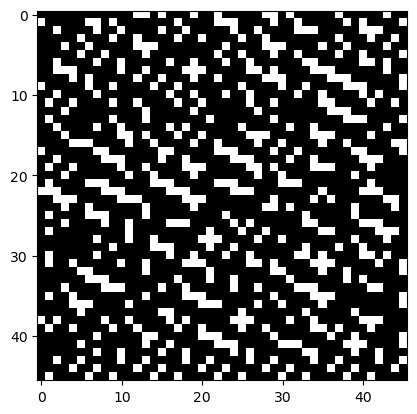

In [13]:
img, kd = train_dataset.__getitem__(0)
print('img shape:', img.shape, ', kd:', kd)
plt.imshow(img, cmap='gray')

In [ ]:
it = iter(train_loader)